# Install dependencies

In [1]:
#!pip install lime
#!pip install keras tensorflow

In [2]:
#!pip -V

# Import libraries

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Dense, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error
from scipy import stats
#import tensorflow as tf
import pickle as pk
# for ploting data
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# to explain local cases and understand the model's decision
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
# for matrix operation
import numpy as np

#for table manipulation
import pandas as pd

# garbage collector
import gc

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

Using Theano backend.


# Adapter

In [4]:
class MyModel():
    def __init__(self,model,ty,max=False):
        self.model = model
        self.ty=ty
        self.max=True
    def predict(self, img):
        img = np.array(img)
        if(len(img.shape)==3):
            if(self.ty=='rf'):
                data=img[:,:,0].reshape(1, img.shape[0]*img.shape[1])
            else:
                data=img[:,:,0].reshape(1, img.shape[0], img.shape[1], 1)
        else:
            if(self.ty=='rf'):
                data=img[:,:,:,0].reshape(img.shape[0], img.shape[1]*img.shape[2])
            else:
                data=img[:,:,:,0].reshape(img.shape[0], img.shape[1], img.shape[2], 1)
        pred=self.model.predict(data)
        return pred

# configuration

In [5]:
batch_size = 128
num_classes = 10
epochs = 1

In [6]:
# input image dimensions
img_rows, img_cols = 28, 28

# Getting the data

In [39]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Show Data

In [58]:
values = list(range(10))
idxs = [np.argwhere(y_train == value)[0][0] for value in values]

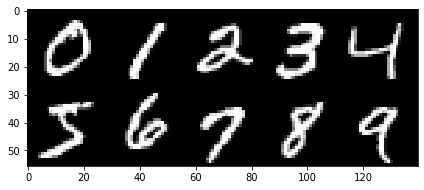

In [62]:
rows=x_train.shape[1]
cols=x_train.shape[2]
cases=np.zeros((rows*2, cols*5))
for value, idx in zip(values, idxs):
    cases[(value//5)*rows:((value//5)+1)*rows,(value%5)*cols:((value%5)+1)*cols] = x_train[idx, :, :]
plt.imshow(cases, plt.cm.gray)
plt.show()

# Parser

In [8]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    
    x_train_2d=np.array([[[x[0] for x in y]for y in a]for a in x_train])
    x_test_2d=np.array([[[x[0] for x in y]for y in a]for a in x_test])

    x_train_1d=x_train.reshape(x_train.shape[1], x_train.shape[2]*x_train.shape[3])
    x_test_1d=x_test.reshape(x_test.shape[1], x_test.shape[2]*x_test.shape[3])
    x_train_1d=np.array(x_train_1d)
    x_test_1d=np.array(x_test_1d)    
    print(x_train_1d.shape, x_test_1d.shape)
    input_shape = (1,img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    x_train_2d=np.array([[[x[0] for x in y]for y in a]for a in x_train])
    x_test_2d=np.array([[[x[0] for x in y]for y in a]for a in x_test])
    x_train_1d=x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
    x_test_1d=x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    print(x_train_1d.shape, x_test_1d.shape)
    input_shape = (img_rows, img_cols,1)

(60000, 784) (10000, 784)


In [9]:
x_train.shape

(60000, 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [10]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
input_shape

(28, 28, 1)

# Models

## ANN

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [13]:
%%time
amount=1000
model.fit(x_train[:amount], y_train[:amount],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1000 samples, validate on 10000 samples
Epoch 1/1
1000/1000 [==============================] - 36s 36ms/step - loss: 12.6646 - accuracy: 0.1820 - val_loss: 12.1612 - val_accuracy: 0.2262
Test loss: 12.161160316467285
Test accuracy: 0.22619999945163727
CPU times: user 1min 20s, sys: 11.8 s, total: 1min 32s
Wall time: 12min 41s


## RF

In [14]:
%%time
rdm_forest=RandomForestClassifier(n_estimators=200)
rdm_forest=rdm_forest.fit(X=x_train_1d[:amount], 
                          y=y_train[:amount])

CPU times: user 1.02 s, sys: 4.73 ms, total: 1.03 s
Wall time: 1.03 s


In [15]:
#with open('data.pkl','wb') as f:
#    pk.dump(img,f)

In [16]:
#with open('models.pkl','rb') as f:
#    [model,rdm_forest]=pk.load(f)

# Lime

In [17]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift',
                                  kernel_size=1,
                                  max_dist=200,
                                  ratio=0.2)

In [18]:
%%time
case=2
explanation = explainer.explain_instance(np.array([[[x[0],x[0],x[0]]
                                                    for x in y]
                                                   for y in x_test[case]]), 
                                         classifier_fn =MyModel(rdm_forest,
                                                                'rf').predict, 
                                         top_labels=10,
                                         hide_color=0,
                                         num_samples=10000,
                                         segmentation_fn=segmenter,
                                         labels=np.array([str(x) 
                                                          for x in range(10)]))

CPU times: user 32.5 s, sys: 185 ms, total: 32.7 s
Wall time: 32.4 s


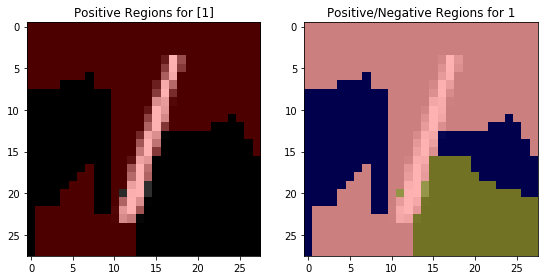

In [19]:
temp, mask = explanation.get_image_and_mask(int(np.where(y_test[case]==1)[0]),
                                            positive_only=True,
                                            num_features=10,
                                            hide_rest=False,
                                            min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(np.where(y_test[case]==1)[0]))
temp, mask = explanation.get_image_and_mask(int(np.where(y_test[case]==1)[0]),
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False,
                                            min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(int(np.where(y_test[case]==1)[0])))
plt.savefig('test.png')

# Tester

## Class

In [20]:
class Tester:
    def __init__(self,name1, model1, type1,name2, model2, type2, classes):
        self.models={}
        self.models[name1]=MyModel(model1,type1)
        self.models[name2]=MyModel(model2,type2)
        self.classes=classes
        self.names=(name1, name2)
        self.cases=('cc', 'ci', 'ic','ii')
        self.num_classes=len(self.classes)

    def __repr__():
        return self.models.__repr__()+'\n'+self.classes.__repr__()
    def lime_test_case(self, model,case,y, filename=None):
        explainer = lime_image.LimeImageExplainer(verbose = False)
        explain=explainer.explain_instance
        explanation = explain(np.array([[[x[0],x[0],x[0]]
                                            for x in image]
                                        for image in case]), 
                                classifier_fn =self.models[model].predict, 
                                top_labels=10,
                                hide_color=0,
                                num_samples=10000,
                                segmentation_fn=segmenter,
                                labels=np.array([str(x) 
                                            for x in range(10)]))
        print(y)
        temp, mask = explanation.get_image_and_mask(y,
                                                    positive_only=True,
                                                    num_features=10,
                                                    hide_rest=False,
                                                    min_weight = 0.01)
        print(self.models[model].ty)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
        ax1.imshow(label2rgb(mask,temp, bg_label = 0), 
                   interpolation = 'nearest')
        ax1.set_title('Positive Regions for {}'.format(y))
        temp, mask = explanation.get_image_and_mask(y,
                                                    positive_only=False,
                                                    num_features=10,
                                                    hide_rest=False,
                                                    min_weight = 0.01)
        ax2.imshow(label2rgb(3-mask,
                             temp,
                             bg_label = 0),
                    interpolation = 'nearest')
        ax2.set_title('Positive/Negative Regions for {}'.format(y))
        if(filename!=None):
            plt.savefig(filename)
        plt.show()
    
    
    
    
    
    def plot_confusion_matrix(self, y_true, y_pred, classes,
                                normalize=False,
                                title=None,
                                filename='test.pdf',
                                dirname='',
                                cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data

        classes = classes[unique_labels(y_true, y_pred)]
        print('classes:', classes)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
                yticks=np.arange(cm.shape[0]),
                # ... and label them with the respective list entries
                xticklabels=classes, yticklabels=classes,
                title=title,
                ylabel='True label',
                xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
                    rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.savefig(dirname+filename)
        plt.show()
        return ax
    def confmatrix_test(self,x_train,x_test,y_train,y_test):
        proy_train=[np.where(y==np.max(y))[0][0] for y in y_train]
        proy_test=[np.where(y==np.max(y))[0][0] for y in y_test]
        filenames={}
        for name,model in self.models.items():
            print(name, 'runing predictors')
            pred_train= [np.where(y==np.max(y))[0][0]
                         for y in model.predict(x_train)]
            pred_test= [np.where(y==np.max(y))[0][0]
                        for y in model.predict(x_test)]
            print(pred_train[0],pred_test[0])
            filenames[name]={}
            filenames[name]['conf']={'tr': name+'trainconf.png',
                                     'ts': name+'testconf.png'}
            print('generating conf matrices')
            self.plot_confusion_matrix(proy_train,
                                       pred_train,
                                       self.classes,
                                       title=name+'training confution matrix',
                                       filename=name+'trainconf.png')
            self.plot_confusion_matrix(proy_test,
                                       pred_test,
                                       self.classes,
                                       title=name+'test confution matrix',
                                       filename=name+'testconf.png')
            
        return filenames


    def stats(self,x_train,x_test,y_train,y_test,loss='mse'):
        proy_train=[np.where(y==np.max(y))[0][0] for y in y_train]
        proy_test=[np.where(y==np.max(y))[0][0] for y in y_test]
        scores={}
        names=self.names
        for name,model in self.models.items():
            pred_train= model.predict(x_train)
            pred_test= model.predict(x_test)
            pred1_train= [np.where(y==np.max(y))[0][0]
                         for y in pred_train]
            pred1_test= [np.where(y==np.max(y))[0][0]
                        for y in pred_test]
            with open('preddata.pkl','wb') as f:
                pk.dump([proy_train,
                         proy_test,
                         pred_train,
                         pred_test,
                         pred1_train,
                         pred1_test],
                        f)
            scores[name]={}
            scores[name]['acc']={'tr':accuracy_score(proy_train,pred1_train),
                                'ts':accuracy_score(proy_test,pred1_test)}
            scores[name]['loss']={
                                  'tr':mean_squared_log_error(np.array(y_train),
                                                              np.array(pred_train)),
                                  'ts':mean_squared_log_error(np.array(y_test),
                                                              np.array(pred_test))}
        accnames=[names[0]+' training',names[0]+ ' test',names[1]+' training',names[1]+ ' test']
        accvals=[scores[names[0]]['acc']['tr'],scores[names[0]]['acc']['ts'],scores[names[1]]['acc']['tr'],scores[names[1]]['acc']['ts']]
        lossnames=[names[0]+' training',names[0]+ ' test',names[1]+' training',names[1]+ ' test']
        lossvals=[scores[names[0]]['loss']['tr'],scores[names[0]]['loss']['ts'],scores[names[1]]['loss']['tr'],scores[names[1]]['loss']['ts']]
        print(accnames)
        print(accvals)
        print(lossnames)
        print(lossvals)
        plt.bar(accnames,accvals)
        plt.savefig('acc.png')
        plt.show()
        plt.bar(lossnames,lossvals)
        plt.savefig('loss.png')
        plt.show()
        return scores

    def lime_test(self,cases,Y,datasetname=None):
        filenames={}
        for idx, (case, pred) in enumerate(zip(cases, Y)):
            print(idx)
            filenames[idx]={}
            for name, values in zip(self.names, pred):
                filenames[idx][name]={}
                for y in set(values):
                    filename = name+datasetname+'lime_'+str(idx)+'_'+str(y)+'.png'
                    self.lime_test_case(name,
                                        case,
                                        y,
                                        filename)
                    filenames[idx][name][y]=filename
        return filenames
    
    
    
    def find_lime_cases(self,x_data,y_data):
        y_proc=[np.argmax(x) for x in y_data]
        cases={}
        for name in self.names:
            model = self.models[name]
            pred=model.predict(x_data)
            sel=dict([(idx, np.argmax(x)) for idx, x in enumerate(pred)
                 if np.max(x) > 0.1])
            cases[name]={}
            cases[name]['correct']={}
            cases[name]['incorrect']={}
            for idx in sel:
                y_pred = sel[idx]
                y_true = y_proc[idx]
                if(y_pred==y_true):
                    cases[name]['correct'][idx] = (y_pred, y_true)
                else:
                    cases[name]['incorrect'][idx] = (y_pred, y_true)
        test_cases={}
        names=self.names
        print(names[0])
        zero_correct = cases[names[0]]['correct']
        zero_incorrect = cases[names[0]]['incorrect']
        one_correct = cases[names[1]]['correct']
        one_incorrect = cases[names[1]]['incorrect']
        for case in zero_correct:
            if(case in one_correct):
                test_cases[self.cases[0]]=(case, (zero_correct[case], one_correct[case]))
                break
        for case in zero_correct:
            if(case in one_incorrect):
                test_cases[self.cases[1]]=(case, (zero_correct[case], one_incorrect[case]))
                break
        for case in zero_incorrect:
            if(case in one_correct):
                test_cases[self.cases[2]]=(case, (zero_incorrect[case], one_correct[case]))
                break
        for case in zero_incorrect:
            if(case in one_incorrect):
                test_cases[self.cases[3]]=(case, (zero_incorrect[case], one_incorrect[case]))
                break
        return test_cases

    def run_test(self,x_train,x_test,y_train,y_test):
        print('finding test cases')
        names = self.names
        casests=self.find_lime_cases(x_test,y_test)
        xselts=[x_test[casests[case][0]] for case in self.cases]
        ypred=[casests[case][1] for case in self.cases]
        print(casests)
        print(self.names)
        print('running lime test')
        filenamests=self.lime_test(xselts,ypred,'ts')
        print('running conf test')
        conffilenames=self.confmatrix_test(x_train,x_test,y_train,y_test)
        print('running stats test')
        stats=self.stats(x_train,x_test,y_train,y_test)
        print('done')
        limeinfo={
            'cc':casests['cc'][1][0][:1],
            'ci':casests['ci'][1][1],
            'ic':casests['ic'][1][0],
            'ii':casests['ii'][1][0][:1] + casests['ii'][1][1]
        }
        print(limeinfo,filenamests,conffilenames,stats)
        return limeinfo,filenamests,conffilenames,stats
   # def generate_report(self, filenamestr,filenamests,conffilenames,stats):
        

## commands

In [21]:
tester=Tester('ANN',model,'ann','RF',rdm_forest,'rf',np.array([str(x) for x in range(10)]))

In [22]:
np.argmax(tester.models['ANN'].predict(x_train[247]))

4

finding test cases


ANN
{'cc': (0, ((7, 7), (7, 7))), 'ci': (376, ((4, 4), (9, 4))), 'ic': (3, ((4, 0), (0, 0))), 'ii': (77, ((4, 2), (7, 2)))}
('ANN', 'RF')
running lime test
0


100% |########################################################################|


7
ann


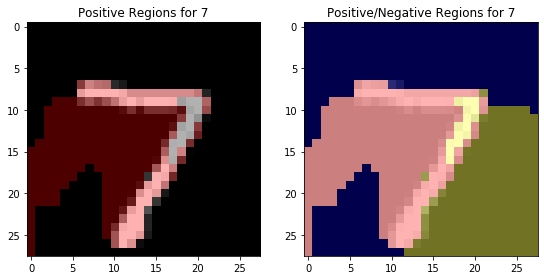

100% |########################################################################|


7
rf


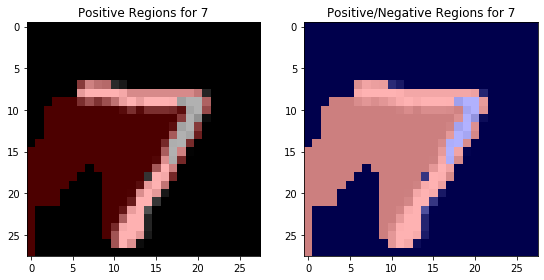

1


100% |########################################################################|


4
ann


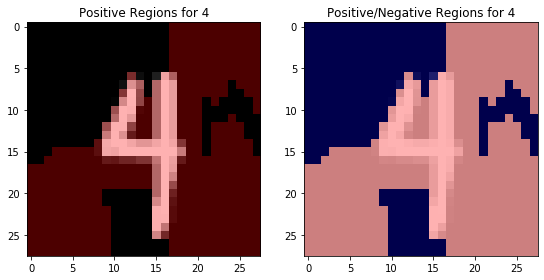

100% |########################################################################|


9
rf


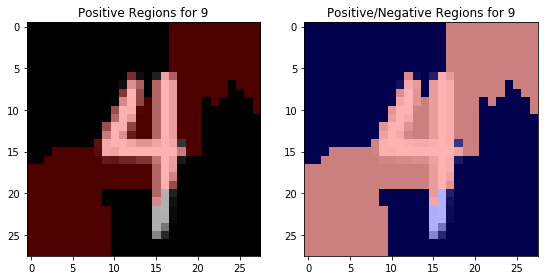

100% |########################################################################|


4
rf


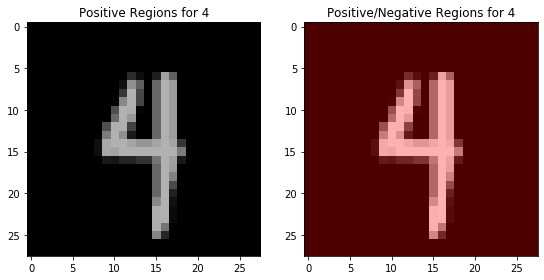

2


100% |########################################################################|


0
ann


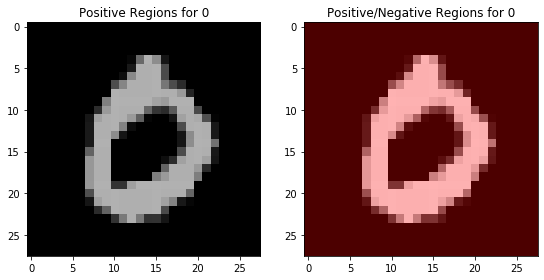

100% |########################################################################|


4
ann


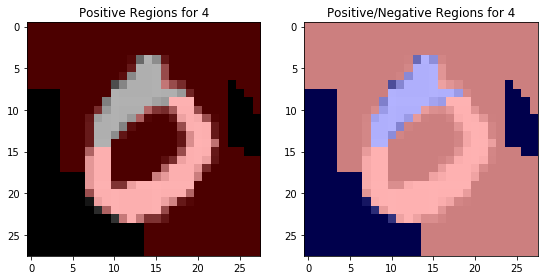

100% |########################################################################|


0
rf


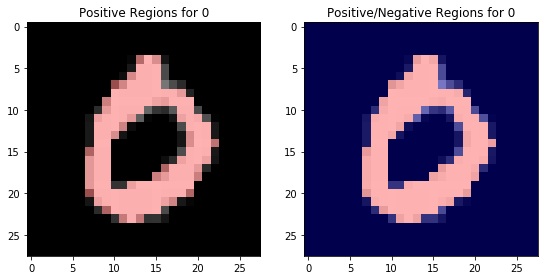

3


100% |########################################################################|


2
ann


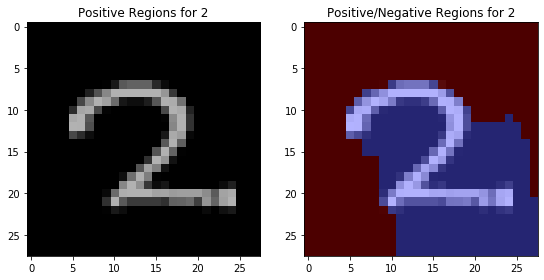

100% |########################################################################|


4
ann


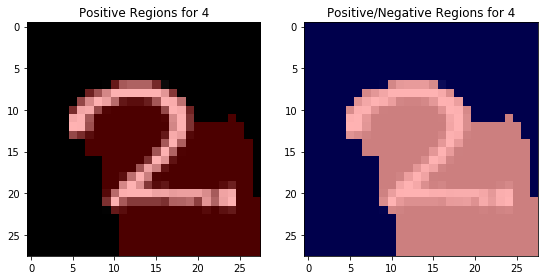

100% |########################################################################|


2
rf


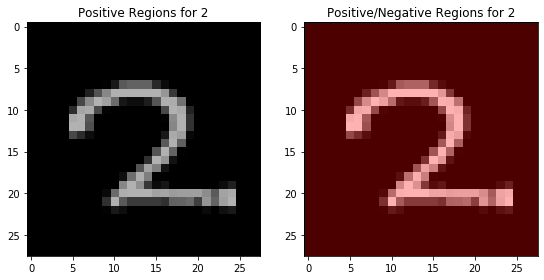

100% |########################################################################|


7
rf


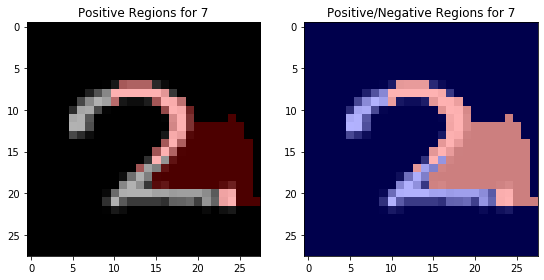

running conf test
ANN runing predictors
6 7
generating conf matrices
classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Confusion matrix, without normalization
[[   0    6    0    0 5859    0   58    0    0    0]
 [   0 6479    0    0  247    0   16    0    0    0]
 [   0  574    0    0 4565    0  817    2    0    0]
 [   0  649    0    0 4833    0  646    1    0    2]
 [   0   13    0    0 5826    0    2    1    0    0]
 [   0  246    0    0 4921   87  166    0    0    1]
 [   0  231    0    0 5365    0  322    0    0    0]
 [   0  237    0    0 5195    0    9  824    0    0]
 [   0  864    0    0 4942    0   45    0    0    0]
 [   0   66    0    0 5872    0    3    3    0    5]]


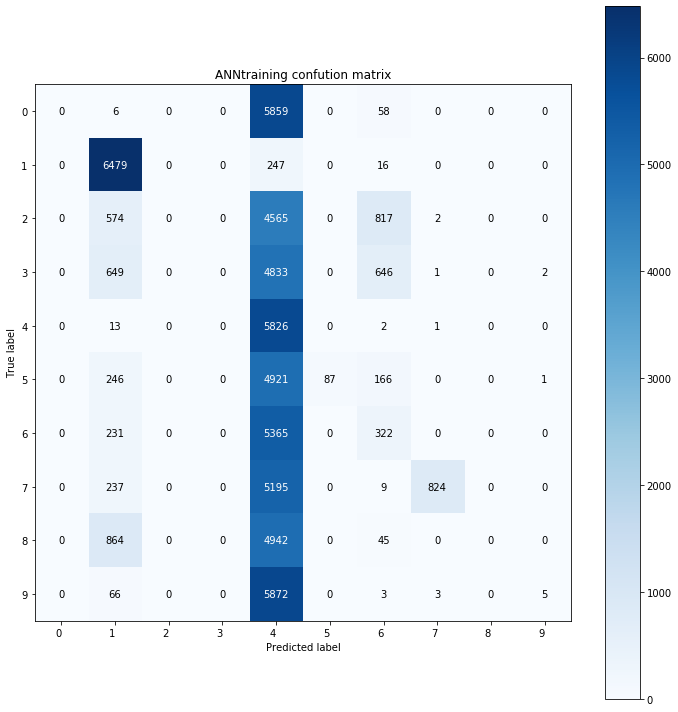

classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Confusion matrix, without normalization
[[   0    0    0    0  972    0    8    0    0    0]
 [   0 1097    0    0   37    0    1    0    0    0]
 [   0  126    0    0  757    0  149    0    0    0]
 [   0   91    0    0  813    0  103    1    0    2]
 [   0    1    0    0  980    0    1    0    0    0]
 [   0   53    0    0  788   10   41    0    0    0]
 [   0   25    0    0  888    0   45    0    0    0]
 [   0   44    0    0  855    0    0  129    0    0]
 [   0   83    0    0  885    0    6    0    0    0]
 [   0   11    0    0  995    0    2    0    0    1]]


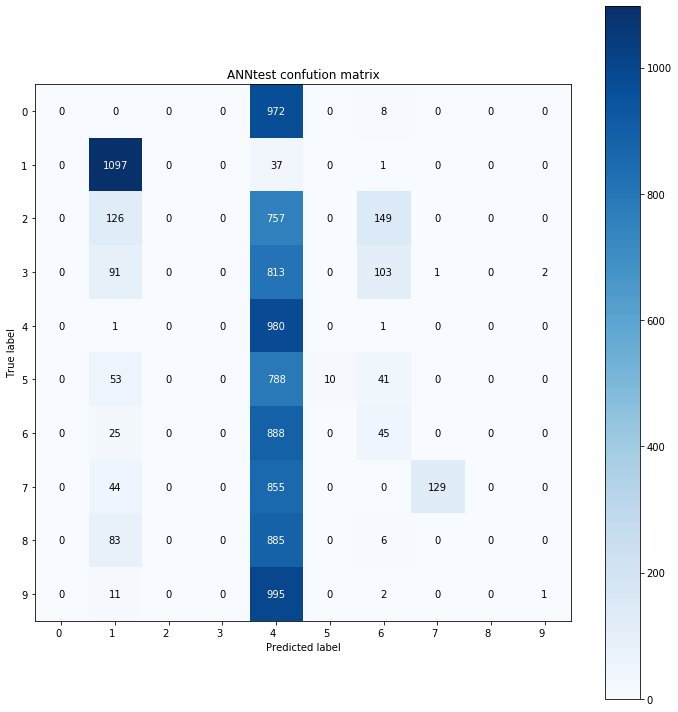

RF runing predictors
5 7
generating conf matrices
classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Confusion matrix, without normalization
[[5922    0    0    0    0    0    1    0    0    0]
 [ 555 6183    2    0    0    0    0    1    1    0]
 [3218    6 2714    0    2    0    1   14    3    0]
 [3784    3    4 2313    0   16    0   10    0    1]
 [2609    2    0    0 3194    0    2    1    1   33]
 [3927    8    0    2    1 1478    4    0    1    0]
 [2391    6    0    0    6    1 3514    0    0    0]
 [1538    5    3    0    2    0    0 4704    0   13]
 [4042   24    2    0    1    0    0    0 1773    9]
 [2884    2    1    0   16    0    0   25    0 3021]]


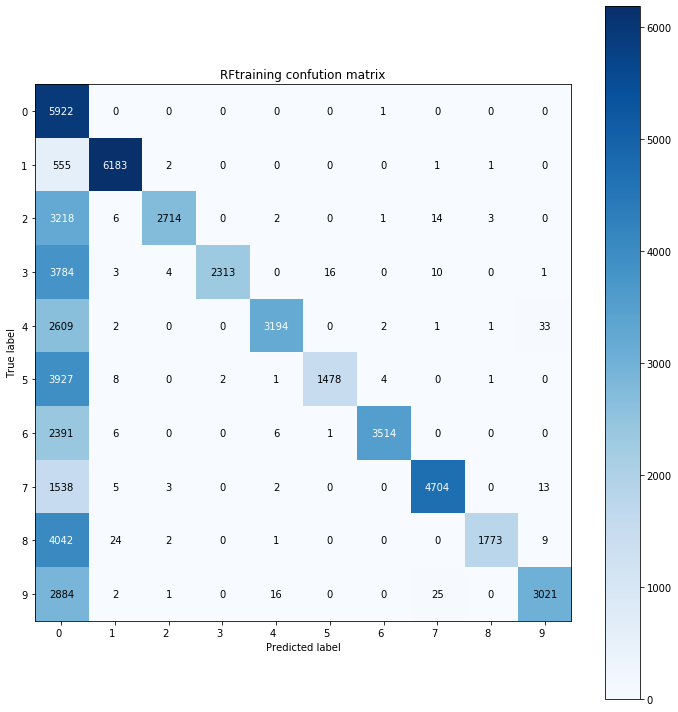

classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Confusion matrix, without normalization
[[ 980    0    0    0    0    0    0    0    0    0]
 [  90 1045    0    0    0    0    0    0    0    0]
 [ 529    0  497    0    0    0    0    5    1    0]
 [ 630    0    0  375    0    3    0    2    0    0]
 [ 432    0    0    0  544    0    1    0    0    5]
 [ 650    2    0    0    0  239    0    1    0    0]
 [ 407    2    0    0    3    0  546    0    0    0]
 [ 251    1    4    0    0    0    0  769    0    3]
 [ 716    1    0    0    1    0    0    0  253    3]
 [ 488    1    0    0    2    0    0    1    0  517]]


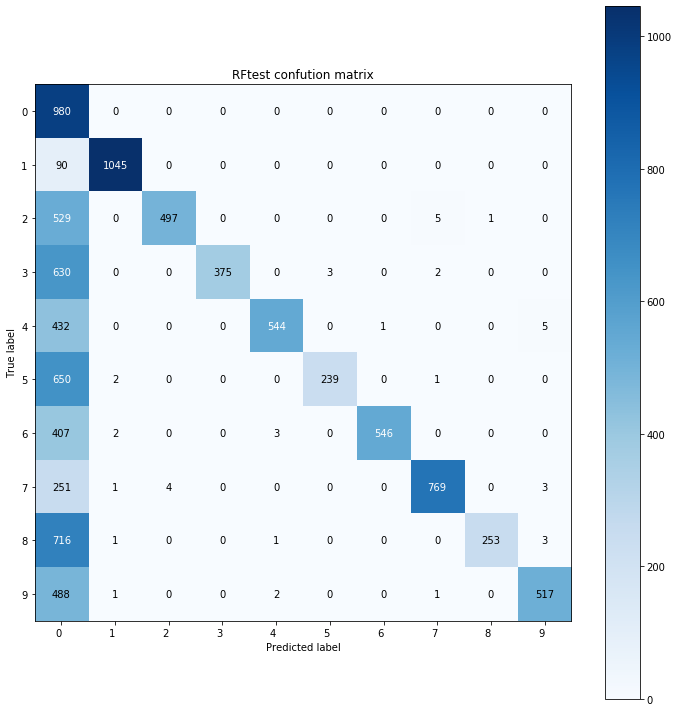

running stats test
['ANN training', 'ANN test', 'RF training', 'RF test']
[0.22571666666666668, 0.2262, 0.5802666666666667, 0.5765]
['ANN training', 'ANN test', 'RF training', 'RF test']
[0.073956564, 0.073942155, 0.02133243, 0.021466596]


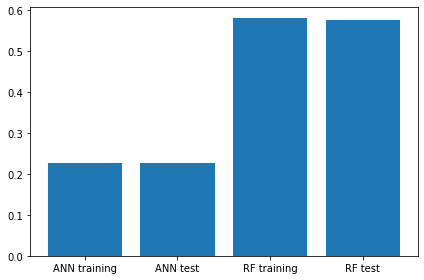

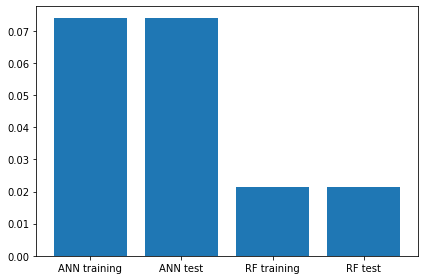

done
{'cc': (7,), 'ci': (9, 4), 'ic': (4, 0), 'ii': (4, 7, 2)} {0: {'ANN': {7: 'ANNtslime_0_7.png'}, 'RF': {7: 'RFtslime_0_7.png'}}, 1: {'ANN': {4: 'ANNtslime_1_4.png'}, 'RF': {9: 'RFtslime_1_9.png', 4: 'RFtslime_1_4.png'}}, 2: {'ANN': {0: 'ANNtslime_2_0.png', 4: 'ANNtslime_2_4.png'}, 'RF': {0: 'RFtslime_2_0.png'}}, 3: {'ANN': {2: 'ANNtslime_3_2.png', 4: 'ANNtslime_3_4.png'}, 'RF': {2: 'RFtslime_3_2.png', 7: 'RFtslime_3_7.png'}}} {'ANN': {'conf': {'tr': 'ANNtrainconf.png', 'ts': 'ANNtestconf.png'}}, 'RF': {'conf': {'tr': 'RFtrainconf.png', 'ts': 'RFtestconf.png'}}} {'ANN': {'acc': {'tr': 0.22571666666666668, 'ts': 0.2262}, 'loss': {'tr': 0.073956564, 'ts': 0.073942155}}, 'RF': {'acc': {'tr': 0.5802666666666667, 'ts': 0.5765}, 'loss': {'tr': 0.02133243, 'ts': 0.021466596}}}
CPU times: user 7min 53s, sys: 43.1 s, total: 8min 36s
Wall time: 6min 4s


In [23]:

%%time
limeinfo,filenamests,conffilenames,stats=tester.run_test(x_train,x_test,y_train,y_test)

In [24]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [25]:
def generate(limeinfo,filenamests,conffilenames,stats,models):
    print(limeinfo,
          '\n_________________________________\n',
          filenamests,
          '\n_________________________________\n',
          conffilenames,
          '\n_________________________________\n',
          stats,
         '\n_________________________________\n')
    with open('tamplate.md','r') as f:
        template=f.read()
    
    name1=models[0]
    name2=models[1]
    cc=limeinfo['cc'][0]
    text=template.replace('occ_',str(cc))
    
    text=text.replace('model1',name1).replace('model2',name2)
    print(name1,name2)
    # Lime
    
    
    # correct-correct
    text=text.replace('_lgcc1_',name1+' true')
    text=text.replace('_lgcc2_',name2+' true')
    text=text.replace('_filenamelgcc1_',filenamests[0][name1][cc])
    text=text.replace('_filenamelgcc2_',filenamests[0][name2][cc])
    
    # correct-incorrect
    ci_pred=limeinfo['ci'][0]
    ci_true=limeinfo['ci'][1]
    text=text.replace('oci_',str(ci_true))
    text=text.replace('oci2',str(ci_pred))
    text=text.replace('_lgci1_',name1+' true')
    text=text.replace('_lgci2c_',name2+' true')
    text=text.replace('_lgci2p_',name2+' predicted')
    text=text.replace('_filenamelgci1_',filenamests[1][name1][ci_true])
    text=text.replace('_filenamelgci2c_',filenamests[1][name2][ci_true])    
    text=text.replace('_filenamelgci2p_',filenamests[1][name2][ci_pred])    
    
    # incorrect-correct
    ic_pred=limeinfo['ic'][0]
    ic_true=limeinfo['ic'][1]
    text=text.replace('oic_',str(ic_true))
    text=text.replace('oic1',str(ic_pred))
    text=text.replace('_lgic1c_',name1+' true')
    text=text.replace('_lgic1p_',name1+' predicted')
    text=text.replace('_lgic2_',name2+' true')
    text=text.replace('_filenamelgic1c_',filenamests[2][name1][ic_true])
    text=text.replace('_filenamelgic1p_',filenamests[2][name1][ic_pred])    
    text=text.replace('_filenamelgic2_',filenamests[2][name2][ic_true])    
    
    # incorrect-incorrect
    ii_pred1=limeinfo['ii'][0]
    ii_pred2=limeinfo['ii'][1]
    ii_true=limeinfo['ii'][2]
    text=text.replace('oii_',str(ii_true))
    text=text.replace('oii1',str(ii_pred1))
    text=text.replace('oii2',str(ii_pred2))
    text=text.replace('_lgii1p_',name1+' predicted')
    text=text.replace('_lgii2p_',name2+' predicted')
    text=text.replace('_lgii1c_',name1+' true')
    text=text.replace('_lgii2c_',name2+' true')
    text=text.replace('_filenamelgii1p_',filenamests[3][name1][ii_pred1])
    text=text.replace('_filenamelgii1c_',filenamests[3][name1][ii_true])
    text=text.replace('_filenamelgii2c_',filenamests[3][name2][ii_true])
    text=text.replace('_filenamelgii2p_',filenamests[3][name2][ii_pred2])
    
    
    # conf matrices
    text=text.replace('_cg1tr_',name1 +' training confution matrix')
    text=text.replace('_cg1ts_',name1 +' test confution matrix')
    text=text.replace('_cg2tr_',name2 +' training confution matrix')
    text=text.replace('_cg2ts_',name2 +' test confution matrix')
    
    text=text.replace('_filenamecg1tr_',conffilenames[name1]['conf']['tr'])
    text=text.replace('_filenamecg1ts_',conffilenames[name1]['conf']['ts'])
    text=text.replace('_filenamecg2tr_',conffilenames[name2]['conf']['tr'])
    text=text.replace('_filenamecg2ts_',conffilenames[name2]['conf']['ts'])
    # stats
    
    text=text.replace('tracc1val',str(stats[name1]['acc']['tr']))
    text=text.replace('tsacc1val',str(stats[name1]['acc']['ts']))
    text=text.replace('tracc2val',str(stats[name2]['acc']['tr']))
    text=text.replace('tsacc2val',str(stats[name2]['acc']['ts']))
    text=text.replace('trloss1val',str(stats[name1]['loss']['tr']))
    text=text.replace('tsloss1val',str(stats[name1]['loss']['ts']))
    text=text.replace('trloss2val',str(stats[name2]['loss']['tr']))
    text=text.replace('tsloss2val',str(stats[name2]['loss']['ts']))
    
    text=text.replace('_filenameacc_','acc.png')
    text=text.replace('_filenameloss_','loss.png')
    print(text)
    with open('report.md','w') as f:
        f.write(text)
    print(text)

In [26]:
limeinfo

{'cc': (7,), 'ci': (9, 4), 'ic': (4, 0), 'ii': (4, 7, 2)}

In [27]:
generate(limeinfo,filenamests,conffilenames,stats,tester.names)

{'cc': (7,), 'ci': (9, 4), 'ic': (4, 0), 'ii': (4, 7, 2)} 
_________________________________
 {0: {'ANN': {7: 'ANNtslime_0_7.png'}, 'RF': {7: 'RFtslime_0_7.png'}}, 1: {'ANN': {4: 'ANNtslime_1_4.png'}, 'RF': {9: 'RFtslime_1_9.png', 4: 'RFtslime_1_4.png'}}, 2: {'ANN': {0: 'ANNtslime_2_0.png', 4: 'ANNtslime_2_4.png'}, 'RF': {0: 'RFtslime_2_0.png'}}, 3: {'ANN': {2: 'ANNtslime_3_2.png', 4: 'ANNtslime_3_4.png'}, 'RF': {2: 'RFtslime_3_2.png', 7: 'RFtslime_3_7.png'}}} 
_________________________________
 {'ANN': {'conf': {'tr': 'ANNtrainconf.png', 'ts': 'ANNtestconf.png'}}, 'RF': {'conf': {'tr': 'RFtrainconf.png', 'ts': 'RFtestconf.png'}}} 
_________________________________
 {'ANN': {'acc': {'tr': 0.22571666666666668, 'ts': 0.2262}, 'loss': {'tr': 0.073956564, 'ts': 0.073942155}}, 'RF': {'acc': {'tr': 0.5802666666666667, 'ts': 0.5765}, 'loss': {'tr': 0.02133243, 'ts': 0.021466596}}} 
_________________________________

ANN RF
# Models Report
## Lime test
### Correct-Correct

true output: 7

####

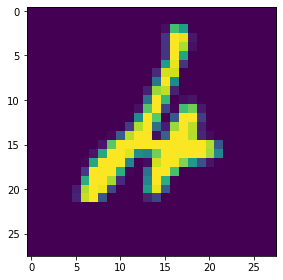

In [28]:
plt.imshow(x_test[247,:,:,0])

In [29]:
#!git add *
#!git commit -m 'Update'
#!git push

In [30]:
#!git push --h